Make the CIV plot, but this time also include the 388/8403 color-selected that overlapped with the LOFAR footprint (Shimwell+2019).

Note that we need to divide our EW values by 1+z to match Amy's

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import richardsplot
import sklearn
from scipy.stats import gaussian_kde
%matplotlib inline
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [4]:
#Equations

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def radluminosity(nu1, nu2, S, alpha, z):
    #calculate luminosity at nu1 based on flux at nu2
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    L = ((4*np.pi*DL**2*(S*1e-23*1e-6)) / ((1+z)**(1+alpha))) * (nu1/nu2)**alpha * 1e-7
    return np.log10(L)

def fluxdensity(nu1, nu2, L, alpha, z):
    #calculate flux density at nu2 based on luminosity at nu1
    L = 10.**L
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    S = L * (nu2/nu1)**alpha * (((1+z)**(1+alpha))/(4*np.pi*DL**2)) * 1e36
    return S #return flux density in microJy

def SFR_L14(L14):
    #Yun+2001 SFR relation based on 1.4GHz luminosity
    return 5.9e-22 * (10**L14)

def SFR_Mi(Mi):
    #Absolute magnitude SFR relation from Harris+2016
    return -29*Mi**2 - 1638*Mi - 22505

def SFR_eqw(E):
    #Equation 8 of Harris+2016 - compute SFR given EQW measurements
    return 4205*E**(-.5) - 328

def plot_contour(xdata, ydata, c="k", nlevels=3, ax=None):
    if ax is None:
        ax = plt.gca()
    xmin, xmax = xdata.min(), xdata.max()
    ymin, ymax = ydata.min(), ydata.max()
    X, Y = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([xdata, ydata])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    
    #ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c)
    levels = ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c).levels
    
    for i in range(len(xdata)):
        #These are the indices of the ith's point location in Z (the density estimation) - probably the only tricky part about this
        xind = abs(X[:,0] - positions[0, abs(positions[0] - xdata[i]).argmin()]).argmin()
        yind = abs(Y[0,:] - positions[1, abs(positions[1] - ydata[i]).argmin()]).argmin()
        
        if Z[xind,yind] < levels[1]: #Plot the scatter point if it's below outermost contour level
            ax.scatter(xdata[i], ydata[i], color=c, s=10)#, label="VLA Detections")

----

Load in data for 50 VLA objects.  Going to need the following:

- 3-GHz flux densities (they're 1.4-GHz for the two FIRST sources) to be converted to $L_\mathrm{3GHz}$
- $M_i(z=2)$ for the one Harris SFR relation
- EW for the other SFR relation
- C$_\mathrm{IV}$ EW/blueshift to place the quasars in that space

In [5]:
vla = pd.read_csv("../SpringFinalFigs_moreParams.csv")
vla.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,col1,name,follow_up,RMS,peak_flux,...,ICA_CIV_BLUESHIFT,ICA_CIV_EQW,ICA_CIV_EQW_new2021,RM_DIST_UNSCALE,RM_DIST_SCALE,CIV_BLUESHIFT_SCALED,CIV_EQW_SCALED,CIVBestfit_Index,L3GHz [W/Hz],CIV_DIST_021721
0,0,0,0,0,0,233,SDSSJ001342.45-002412.6,0,9.8,163.0,...,1488.886594,101.160257,35.900650,1728.413701,3.486256,0.722760,-0.879689,275801.0,24.469498,3.506315
1,1,1,1,1,1,293,SDSSJ014023.83+141151.7,0,25.0,516.0,...,172.315874,95.079534,33.912371,414.691980,2.589969,-0.319656,-0.943523,238121.0,24.841584,2.618358
2,2,2,2,2,2,1270,SDSSJ014658.21-091505.2,0,10.0,30.0,...,406.588017,97.289514,34.648832,646.782974,2.704445,-0.134167,-0.920323,244881.0,23.606351,2.734290
3,3,3,3,3,3,1281,SDSSJ015720.27-093809.1,0,14.3,42.9,...,557.606423,122.740901,43.720855,796.239578,2.635625,-0.014596,-0.653142,240918.0,23.761645,2.685961
4,4,4,4,4,4,7944,SDSSJ081656.84+492438.1,1,8.7,26.1,...,1250.742184,102.881571,36.524054,1490.190560,3.289717,0.534205,-0.861619,269740.0,23.545828,3.312861


In [6]:
S3 = vla[["int_flux"]].values.flatten()
z_vla = vla[["redshift_1"]].values.flatten()
L3 = radluminosity(3., 3., S3, -0.7, z_vla)
det_vla = (vla[["detection"]].values.flatten()==1)
D_vla = vla[["detection"]].values.flatten() + vla[['FIRST']].values.astype("int").flatten()
ew_vla_old = vla[["ICA_CIV_EQW"]].values.flatten() / (1+z_vla)
ew_vla = vla[["ICA_CIV_EQW_new2021"]].values.flatten()
voff_vla = vla[["ICA_CIV_BLUESHIFT"]].values.flatten()
Mi_vla = vla[["MI_Z2"]].values.flatten()
SFRavg_vla = (SFR_Mi(Mi_vla) + SFR_eqw(ew_vla)) / 2.

#Compare with catalog values to see what's going on
voff_cat = vla[["VOFF_CIV_PEAK_1"]].values.flatten()
ew_cat = vla[["EW_CIV_1"]].values.flatten()

Now load in parent sample that is in LOFAR footprint

In [7]:
lofar = pd.read_csv("LOFAR_from8403colorselected_all388_CIV.csv")
lofar.sort_values("name", inplace=True)
good = lofar[["good"]].values.flatten()
lofar_det = pd.read_csv("LOFAR_from8403colorselected_detections123_1arcsec.csv")
lofar_det.sort_values("name", inplace=True)
lofar_det.head()

,col1,name,RA_1,Dec_1,Source_Name,RA_2,E_RA,E_RA_tot,DEC_2,E_DEC,...,E_DC_Min,PA,E_PA,DC_PA,E_DC_PA,Isl_rms,S_Code,Mosaic_ID,Isl_id,Separation
15,2206,105245.64+463831.2,163.190206,46.642011,ILTJ105245.70+463830.7,163.190427,0.362932,0.375567,46.641878,0.244608,...,0.540513,106.081950,17.744264,106.081950,17.744264,0.066047,S,P3Hetdex16,5113,0.727160
3,1830,110039.04+510902.3,165.162686,51.150642,ILTJ110039.05+510902.2,165.162688,0.136256,0.156984,51.150616,0.144476,...,0.317960,20.380242,55.903120,20.380242,55.903120,0.067429,S,P4Hetdex16,2296,0.093947
16,2208,110429.51+481637.7,166.122993,48.277147,ILTJ110429.52+481638.0,166.123006,0.435098,0.477744,48.277241,0.259278,...,0.608496,93.276007,21.126713,0.000000,21.126713,0.054989,S,P6,2649,0.341448
4,1832,110853.98+522337.9,167.224924,52.393875,ILTJ110853.96+522337.6,167.224854,0.486835,0.516670,52.393796,0.299093,...,0.700402,84.536970,24.364421,0.000000,24.364421,0.075898,S,P8Hetdex,4605,0.324757
116,8286,111026.20+502403.6,167.609208,50.401021,ILTJ111026.21+502403.8,167.609224,0.490326,0.528534,50.401070,0.292486,...,0.683511,96.225524,27.350117,0.000000,27.350117,0.062552,S,P6,734,0.181365


In [8]:
name = lofar[["name"]].values.flatten() #can use this to pick out detections from Amy's file
name_det = lofar_det[["name"]].values.flatten()
D_lofar = np.array([])
for i in range(len(name)):
    if (name[i]==name_det).any():
        D_lofar = np.append(D_lofar, True)
    else:
        D_lofar = np.append(D_lofar, False)

det_lofar = (D_lofar==1.)

In [9]:
(det_lofar).sum()

123

Good, we have a mask for all the detections in LOFAR

In [10]:
S144 = 210.*np.ones(len(lofar)) #initialize all objects to non-detections
S144[det_lofar] = lofar_det[["Total_flux"]].values.flatten() * 1.e3
z_lofar = lofar[["z_paul"]].values.flatten()
L3_lofar = radluminosity(3., 0.144, S144, -0.7, z_lofar)
ew_lofar = lofar[["CIV_EW"]].values.flatten()
voff_lofar = lofar[["CIV_blue"]].values.flatten()

In [11]:
fit = np.load("RM_CIV_bestFitLine_noScale.npy")
fit[:,1] /= (1+np.median(z_vla))

Maybe should remake the best-fit line at some point (and do we we still want to include the RM objects as "control?"), but some things we can do:

- Compute the CIV distance for the new LOFAR targets, then compute detection fractions of LOFAR objects to compare/augment our own -- it may be useful to consider "detections" as those above *our* sensitivity in the VLA observations, to avoid evolution effects (i.e. use luminosity cutoff not flux)

- Remake CIV plots (maybe with LOFAR points added, but that's alot) -- can check SF excess or deficiency for larger number of targets now

- Could maybe (/should?) filter out the objects Amy classified as having "bad" reconstructions

In [12]:
vla_dist = vla[["CIV_DIST_021721"]].values.flatten() 
lof_dist = lofar[["CIV_DIST_021721"]].values.flatten()

OK, now that we have CIV distance for all objects, I need to go back and see how Gordon defined his boundaries for "low-blueshift high-EW" etc when discussing detections fractions through CIV space.  Then, a simple mask will let us compute detection fractions in the LOFAR objects

Question: How did Gordon compute the uncertainty to our 44% detection fraction (at the beginning of Section 6)?

We have three regions:

- High EW (>140Å -- although now in rest-frame translates to >54Å) --- CIV dist < X
- Moderate EW/blueshift --- X < CIV < Y
- High blueshift (defined by the 6 highest-blueshift VLA sources) --- CIV dist > Y

It turns out these values are X=2.3 and Y=4


In [13]:
lofar_low = (lof_dist<2.4).flatten()
lofar_mid = ((lof_dist>2.4)&(lof_dist<4.)).flatten()
lofar_high = (lof_dist>4.).flatten()
lofar_low.sum(), lofar_mid.sum(), lofar_high.sum()

(42, 288, 58)

In [14]:
print("High-blueshift/low-EW detection fraction = ", (det_lofar&lofar_high).sum() / lofar_high.sum())
print("Mid-blueshift/EW detection fraction      = ", (det_lofar&lofar_mid).sum() / lofar_mid.sum())
print("Low-blueshift/High EW detection fraction = ", (det_lofar&lofar_low).sum() / lofar_low.sum())

High-blueshift/low-EW detection fraction =  0.4827586206896552
Mid-blueshift/EW detection fraction      =  0.2604166666666667
Low-blueshift/High EW detection fraction =  0.47619047619047616


In [15]:
CIV_dist = np.concatenate((vla_dist, lof_dist))
det_mask = np.concatenate((det_vla, det_lofar))

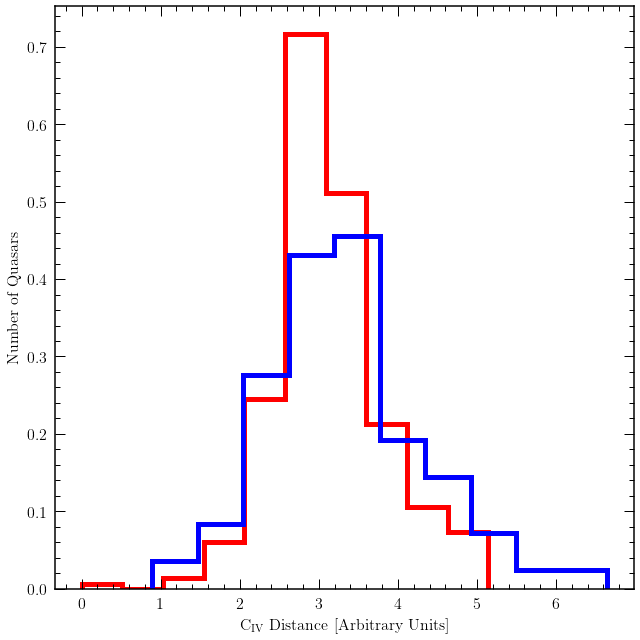

In [16]:
fig = plt.figure(figsize=(9,9))

plt.hist(CIV_dist[det_mask], histtype="step", color="b", linestyle="-", linewidth=5, zorder=2, density=True)
plt.hist(CIV_dist[~det_mask], histtype="step", color="r", linestyle="-", linewidth=5, zorder=1, density=True)

plt.xlabel("C$_\mathrm{IV}$ Distance [Arbitrary Units]")
plt.ylabel("Number of Quasars")
plt.tight_layout()
plt.savefig("CIVdist_histogram.pdf")
plt.show()

In [17]:
voff_lofar_D = voff_lofar[(voff_lofar>-3000)&(det_lofar)]
voff_lofar_ND = voff_lofar[(voff_lofar>-3000)&(~det_lofar)]

ew_lofar_D = ew_lofar[(voff_lofar>-3000)&(det_lofar)]
ew_lofar_ND = ew_lofar[(voff_lofar>-3000)&(~det_lofar)]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


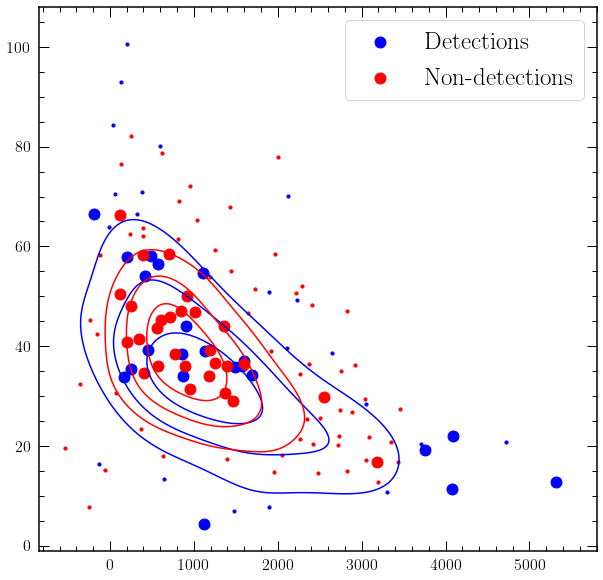

In [18]:
fig = plt.figure(figsize=(10,10))

plot_contour(voff_lofar[det_lofar], ew_lofar[det_lofar], c="blue", nlevels=3, ax=plt.gca())
plot_contour(voff_lofar[~det_lofar], ew_lofar[~det_lofar], c="red", nlevels=3, ax=plt.gca())

plt.scatter(voff_vla[det_vla], ew_vla[det_vla], color="b", s=120, label="Detections")
plt.scatter(voff_vla[~det_vla], ew_vla[~det_vla], color="r", s=120, label="Non-detections")

plt.xlim(-850,5800)
plt.ylim(-1,108)
plt.legend(loc="best", prop={"size": 25})
#plt.savefig("figure111223221.pdf")

In [19]:
#I want to compute detection fractions in a similar way to Figure 3 of Amy R's paper 
min(CIV_dist), max(CIV_dist)

(1.0506757122030924e-05, 6.648730214533362)

In [20]:
CIVlist = np.linspace(0, max(CIV_dist), 9)
det_fraction = np.array([])
det_errs = np.array([])
total = 0
det = 0

for i in range(1, len(CIVlist)):
    for j in range(len(CIV_dist)):
        if CIVlist[i-1] < CIV_dist[j] < CIVlist[i]:
            total += 1
            if det_mask[j]:
                det += 1
    det_fraction = np.append(det_fraction, det/total)
    det_errs = np.append(det_errs, (det**0.5)/total)
    print("%d/%d" % (det, total))
    det = 0
    total = 0

0/1
4/7
24/60
51/203
41/116
16/39
7/10
1/1


In [21]:
det_errs

array([0.        , 0.28571429, 0.08164966, 0.03517945, 0.05519935,
       0.1025641 , 0.26457513, 1.        ])

In [22]:
#I'll manually combine the two edge bins
det_fraction[1] = 4./8
det_errs[1] = 4**.5/8
det_fraction[-2] = 8./12
det_errs[-2] = 8**.5/12
det_fraction = det_fraction[1:-1]
det_errs = det_errs[1:-1]

<ErrorbarContainer object of 3 artists>

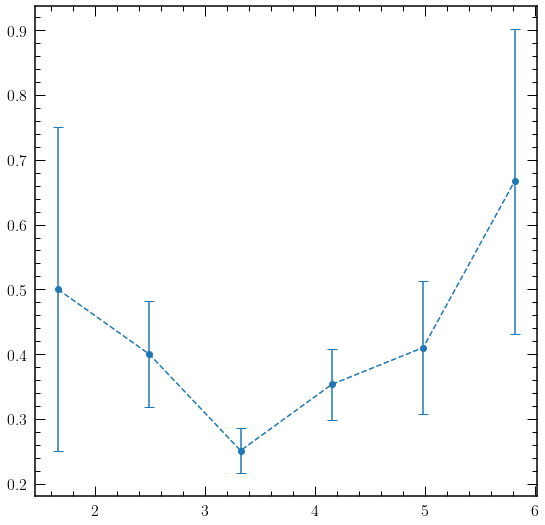

In [23]:
plt.figure(figsize=(9,9))

plt.errorbar(CIVlist[2:-1], det_fraction, yerr=det_errs, fmt="--o", capsize=5)

Let's try to smooth this out -- there aren't many sources on the edge, but lots in the middle

In [24]:
CIVdet = np.array([CIV_dist.flatten(), det_mask]).T
CIVdet

array([[3.50631536e+00, 1.00000000e+00],
       [2.61835810e+00, 1.00000000e+00],
       [2.73428962e+00, 0.00000000e+00],
       [2.68596126e+00, 0.00000000e+00],
       [3.31286110e+00, 0.00000000e+00],
       [4.38643082e+00, 0.00000000e+00],
       [3.54605833e+00, 0.00000000e+00],
       [2.69117210e+00, 0.00000000e+00],
       [2.52634777e+00, 0.00000000e+00],
       [2.32545380e+00, 1.00000000e+00],
       [3.57471855e+00, 1.00000000e+00],
       [2.86145497e+00, 0.00000000e+00],
       [3.24395441e+00, 0.00000000e+00],
       [5.67748012e+00, 1.00000000e+00],
       [3.19304919e+00, 1.00000000e+00],
       [2.99947760e+00, 0.00000000e+00],
       [1.84299627e+00, 0.00000000e+00],
       [2.63490055e+00, 1.00000000e+00],
       [2.15418366e+00, 0.00000000e+00],
       [3.27935114e+00, 0.00000000e+00],
       [2.95242383e+00, 1.00000000e+00],
       [3.14095715e+00, 0.00000000e+00],
       [2.59300197e+00, 0.00000000e+00],
       [5.64452943e+00, 1.00000000e+00],
       [3.494553

In [25]:
CIVsort = CIVdet[CIVdet[:,0].argsort()]

In [26]:
CIVlist = np.array([]) #no longer have specified intervals
det_fraction = np.array([])
det_errs = np.array([])
total = 0
det = 0

for j in range(len(CIVsort)):
    total += 1
    if CIVsort[j,1]:
        det += 1
    if total >= 63:
        det_fraction = np.append(det_fraction, det/total)
        det_errs = np.append(det_errs, (det**0.5)/total)
        CIVlist = np.append(CIVlist, CIVsort[j,0])
        print("%d/%d, %.2f" % (det, total, CIVsort[j,0]))
        det = 0
        total = 0 
det_fraction = np.append(det_fraction, det/total)
det_errs = np.append(det_errs, (det**0.5)/total)
CIVlist = np.append(CIVlist, CIVsort[j-5,0])
print("%d/%d, %.2f" % (det, total, CIVsort[j,0]))
det = 0
total = 0

28/63, 2.47
14/63, 2.74
16/63, 2.95
16/63, 3.25
19/63, 3.55
22/63, 4.02
30/60, 6.65


Text(0.5, 0, 'C$_\\mathrm{IV}$ Distance [Scaled Units]')

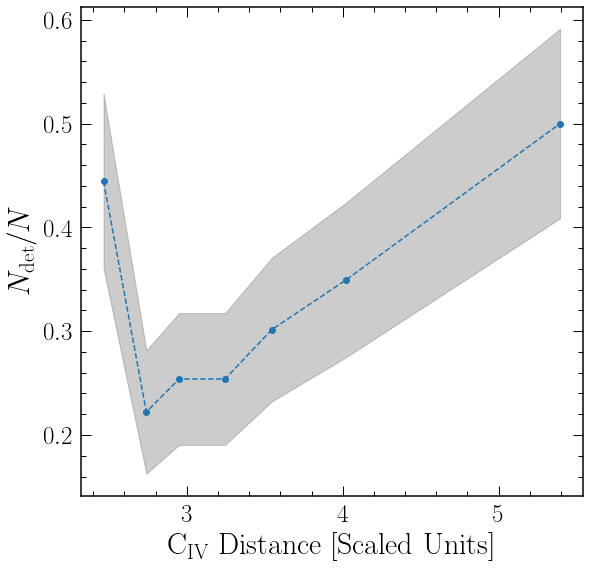

In [27]:
from scipy import interpolate

x = np.arange(min(CIVlist), max(CIVlist), 0.0001)
fp = interpolate.interp1d(CIVlist, det_fraction+det_errs, kind="slinear")
fpp = fp(x)
fm = interpolate.interp1d(CIVlist, det_fraction-det_errs, kind="slinear")
fmm = fm(x)

plt.figure(figsize=(9,9))

plt.plot(CIVlist, det_fraction, "--o")
plt.fill_between(x, fmm, fpp, alpha=0.2, color="k")

plt.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("$N_\mathrm{det}/N$", fontsize=30)
plt.xlabel("C$_\mathrm{IV}$ Distance [Scaled Units]", fontsize=30)

Text(0.5, 0, 'C$_\\mathrm{IV}$ Distance [Scaled Units]')

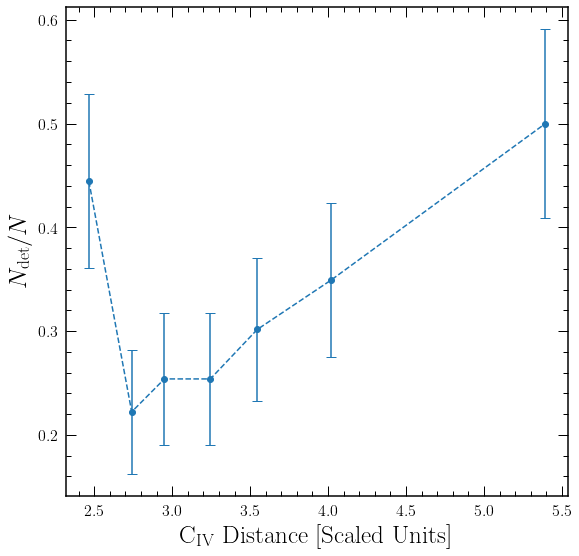

In [28]:
#Now just with the error bars

plt.figure(figsize=(9,9))

plt.errorbar(CIVlist, det_fraction, yerr=det_errs, fmt="--o", capsize=5)

plt.ylabel("$N_\mathrm{det}/N$", fontsize=25)
plt.xlabel("C$_\mathrm{IV}$ Distance [Scaled Units]", fontsize=25)

In [29]:
voff = np.concatenate((voff_vla, voff_lofar))
ew = np.concatenate((ew_vla, ew_lofar))
D = np.concatenate((det_vla, det_lofar))

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


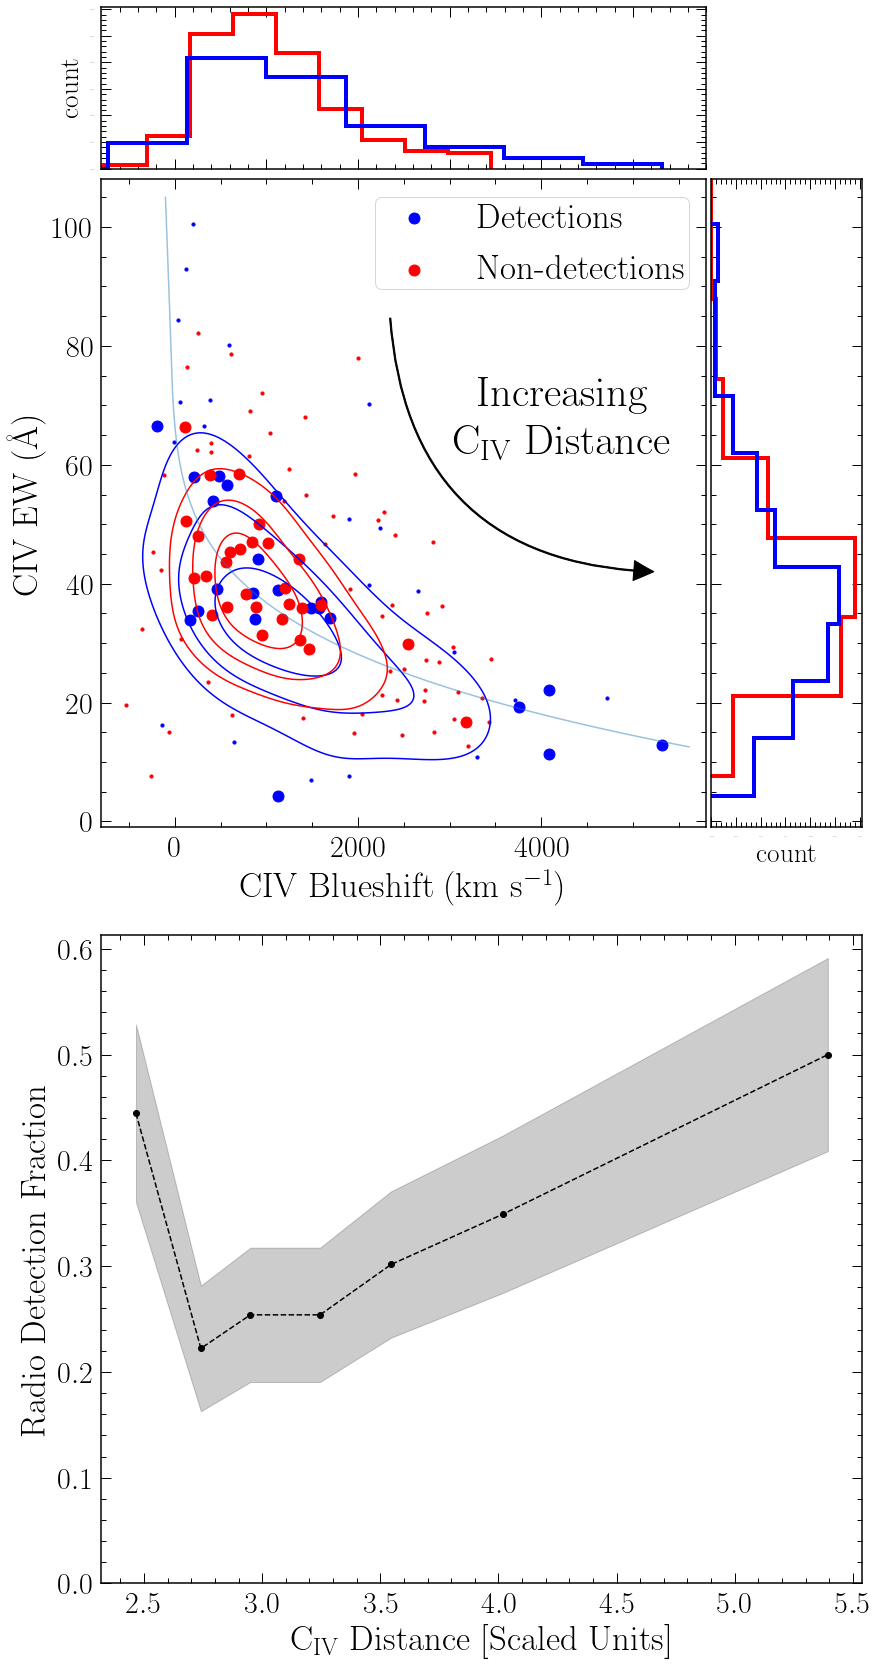

In [30]:
import matplotlib.patches as patches

#ratbins = np.linspace(min(flux_ratio), max(flux_ratio), 21)

# definitions for the axes
left, width = 0.1, 0.6
bottom, height = 0.4, 0.3
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.075]
rect_histy = [left + width + spacing, bottom, 0.15, height]

# start with a rectangular Figure
fig = plt.figure(figsize=(14, 30))


ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)

#Plot the best-fit line
ax_scatter.plot(fit[85000:,0], fit[85000:,1]+5, alpha=0.45)

#Plot scatter data
plot_contour(voff_lofar[det_lofar], ew_lofar[det_lofar], c="blue", nlevels=3, ax=plt.gca())
plot_contour(voff_lofar[~det_lofar], ew_lofar[~det_lofar], c="red", nlevels=3, ax=plt.gca())

plt.scatter(voff_vla[det_vla], ew_vla[det_vla], color="b", s=120, label="Detections")
plt.scatter(voff_vla[~det_vla], ew_vla[~det_vla], color="r", s=120, label="Non-detections")


xlims = ax_scatter.get_xlim() #Save limits before plotting
ax_scatter.set_xlim(-800,5800)
ax_scatter.set_ylim(-1,108)

#ax_scatter.set_yscale("log")
#ax_scatter.set_xlim(xlims)
ax_scatter.tick_params(axis='both', which='major', labelsize=25)


#Plot x axis distribution
ax_histx.hist(voff[~D],align='mid', histtype="step", linewidth=4.0, ls="-", color="r", density=True)
ax_histx.hist(voff[D],align='mid', histtype="step", linewidth=4.0, ls="-", color="b", density=True)
ax_histx.set_ylabel('count', fontsize=27.5)
ax_histx.tick_params(axis='both', which='major', labelsize=0)

ax_histy.hist(ew[~D],align='mid', histtype="step", linewidth=4.0, ls="-", color="r", density=True, orientation='horizontal')
ax_histy.hist(ew[D],align='mid', histtype="step", linewidth=4.0, ls="-", color="b", density=True, orientation='horizontal')
histy_xlims = ax_histy.get_xlim()
#ax_histy.plot([0,20], [1,1], "-k", alpha=0.8)
ax_histy.set_xlabel('count', fontsize=27.5)
ax_histy.tick_params(axis='both', which='major', labelsize=0)

ax_scatter.set_xlabel("CIV Blueshift (km s$^{-1}$)", fontsize=35)
ax_scatter.set_ylabel("CIV EW (Å)", fontsize=35)
ax_scatter.legend(loc="upper right", prop={"size": 35}, borderpad=0.1)
#ax_scatter.set_xlim(22.40, 25.07)
ax_scatter.tick_params(axis='both', which='major', labelsize=30)


#10/31/20: Add curved arrow to indicate increasing CIV distance
style = "Simple, tail_width=1.25, head_width=20, head_length=20"
kw = dict(arrowstyle=style, color="k")
#a1 = patches.FancyArrowPatch((950, 295), (4250, 105),
#                             connectionstyle="arc3,rad=.4", **kw)
a1 = patches.FancyArrowPatch((2350, 85), (5250, 42),
                             connectionstyle="arc3,rad=.45", **kw)
plt.gca().add_patch(a1)
plt.text(x=3300,y=70,s="Increasing", fontsize=42.5, weight='extra bold')
plt.text(x=3035,y=62,s="C$_\mathrm{IV}$ Distance", fontsize=42.5)


ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlim(histy_xlims)
#ax_histx.set_xscale("log")
#ax_histy.set_yscale("log")

#Add another axis for the second panel that we want to include
rect_err = [left, 0.05, width+0.155, height]
ax_err = plt.axes(rect_err)
ax_err.tick_params(direction='in', top=True, right=True)

err_region = True #Activate for err_region -- deactivate for simpler CIV histogram

if err_region:
    ax_err.plot(CIVlist, det_fraction, "--o", color="k")
    ax_err.fill_between(x, fmm, fpp, alpha=0.2, color="k")
    ax_err.tick_params(axis='both', which='major', labelsize=30)
    ax_err.set_ylabel("Radio Detection Fraction", fontsize=35)
    ax_err.set_xlabel("C$_\mathrm{IV}$ Distance [Scaled Units]", fontsize=35)
    ax_err.set_ylim(0.0, ax_err.get_ylim()[1])
    
else:
    ax_err.hist(CIV_dist[det_mask], histtype="step", color="b", linestyle="-", linewidth=5, zorder=2, density=True)
    ax_err.hist(CIV_dist[~det_mask], histtype="step", color="r", linestyle="-", linewidth=5, zorder=1, density=True)
    ax_err.tick_params(axis='both', which='major', labelsize=30)
    ax_err.set_xlabel("C$_\mathrm{IV}$ Distance [Scaled Units]", fontsize=35)
    ax_err.set_ylabel("Number of Quasars", fontsize=35)
    
    
plt.tight_layout()
plt.savefig("CIV_wLOFARcontours_whistos_wDetfraction.pdf")
plt.show()

Note: I connected the contour myself in preview since it was being annoying -- don't bother toying with ``hex_contour`` params since that's about as good as it will get for these data

In [31]:
fit.shape

(330000, 2)

In [32]:
CIVsort

array([[1.05067571e-05, 0.00000000e+00],
       [8.92833914e-01, 1.00000000e+00],
       [1.10079451e+00, 1.00000000e+00],
       [1.33320913e+00, 1.00000000e+00],
       [1.40424757e+00, 0.00000000e+00],
       [1.47364169e+00, 1.00000000e+00],
       [1.51588996e+00, 0.00000000e+00],
       [1.55446763e+00, 0.00000000e+00],
       [1.71712193e+00, 1.00000000e+00],
       [1.72487842e+00, 1.00000000e+00],
       [1.72575199e+00, 0.00000000e+00],
       [1.81364510e+00, 1.00000000e+00],
       [1.82051068e+00, 0.00000000e+00],
       [1.84299627e+00, 0.00000000e+00],
       [1.85803316e+00, 1.00000000e+00],
       [1.90033311e+00, 1.00000000e+00],
       [1.95677701e+00, 0.00000000e+00],
       [1.97441240e+00, 0.00000000e+00],
       [2.01273708e+00, 0.00000000e+00],
       [2.01295143e+00, 1.00000000e+00],
       [2.03330662e+00, 0.00000000e+00],
       [2.05277761e+00, 0.00000000e+00],
       [2.09678136e+00, 1.00000000e+00],
       [2.10725149e+00, 1.00000000e+00],
       [2.154183

In [33]:
vla_low = (vla_dist<2.4).flatten()
vla_mid = ((vla_dist>2.4)&(vla_dist<4.)).flatten()
vla_high = (vla_dist>4.).flatten()

CIV_low = (CIVsort[:,0]<2.4).flatten()
CIV_mid = ((CIVsort[:,0]>2.4)&(CIVsort[:,0]<4.)).flatten()
CIV_high = (CIVsort[:,0]>4.).flatten()
CIV_det = CIVsort[:,1]==1

vla_low.sum(), vla_mid.sum(), vla_high.sum()
#CIV_low.sum(), CIV_mid.sum(), CIV_high.sum()

(9, 35, 6)

In [34]:
print("FINAL DETECTION FRACTIONS\n")

print("LOFAR Objects")
print("High-blueshift/low-EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_lofar&lofar_high).sum(), \
                                                                  lofar_high.sum(), \
                                                                  (det_lofar&lofar_high).sum() / lofar_high.sum(), \
                                                                  ((det_lofar&lofar_high).sum())**0.5/lofar_high.sum()))
print("Mid-blueshift/EW detection fraction      = %2d/%-5d = %7.4f±%.4f" % ((det_lofar&lofar_mid).sum(), \
                                                                  lofar_mid.sum(), \
                                                                  (det_lofar&lofar_mid).sum() / lofar_mid.sum(), \
                                                                  ((det_lofar&lofar_mid).sum())**0.5/lofar_mid.sum()))
print("Low-blueshift/High EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_lofar&lofar_low).sum(), \
                                                                  lofar_low.sum(), \
                                                                  (det_lofar&lofar_low).sum() / lofar_low.sum(), \
                                                                  ((det_lofar&lofar_low).sum())**0.5/lofar_low.sum()))

print("\nVLA Objects")
print("High-blueshift/low-EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_vla&vla_high).sum(), \
                                                                  vla_high.sum(), \
                                                                  (det_vla&vla_high).sum() / vla_high.sum(), \
                                                                  ((det_vla&vla_high).sum())**0.5/vla_high.sum()))
print("Mid-blueshift/EW detection fraction      = %2d/%-5d = %7.4f±%.4f" % ((det_vla&vla_mid).sum(), \
                                                                  vla_mid.sum(), \
                                                                  (det_vla&vla_mid).sum() / vla_mid.sum(), \
                                                                  ((det_vla&vla_mid).sum())**0.5/vla_mid.sum()))
print("Low-blueshift/High EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_vla&vla_low).sum(), \
                                                                  vla_low.sum(), \
                                                                  (det_vla&vla_low).sum() / vla_low.sum(), \
                                                                  ((det_vla&vla_low).sum())**0.5/vla_low.sum()))

print("\nCombined - All 438 Objects")
print("High-blueshift/low-EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((CIV_det&CIV_high).sum(), \
                                                                  CIV_high.sum(), \
                                                                  (CIV_det&CIV_high).sum() / CIV_high.sum(), \
                                                                  ((CIV_det&CIV_high).sum())**0.5/CIV_high.sum()))
print("Mid-blueshift/EW detection fraction      = %2d/%-5d = %7.4f±%.4f" % ((CIV_det&CIV_mid).sum(), \
                                                                  CIV_mid.sum(), \
                                                                  (CIV_det&CIV_mid).sum() / CIV_mid.sum(), \
                                                                  ((CIV_det&CIV_mid).sum())**0.5/CIV_mid.sum()))
print("Low-blueshift/High EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((CIV_det&CIV_low).sum(), \
                                                                  CIV_low.sum(), \
                                                                  (CIV_det&CIV_low).sum() / CIV_low.sum(), \
                                                                  ((CIV_det&CIV_low).sum())**0.5/CIV_low.sum()))

FINAL DETECTION FRACTIONS

LOFAR Objects
High-blueshift/low-EW detection fraction = 28/58    =  0.4828±0.0912
Mid-blueshift/EW detection fraction      = 75/288   =  0.2604±0.0301
Low-blueshift/High EW detection fraction = 20/42    =  0.4762±0.1065

VLA Objects
High-blueshift/low-EW detection fraction =  4/6     =  0.6667±0.3333
Mid-blueshift/EW detection fraction      = 13/35    =  0.3714±0.1030
Low-blueshift/High EW detection fraction =  5/9     =  0.5556±0.2485

Combined - All 438 Objects
High-blueshift/low-EW detection fraction = 32/64    =  0.5000±0.0884
Mid-blueshift/EW detection fraction      = 88/323   =  0.2724±0.0290
Low-blueshift/High EW detection fraction = 25/51    =  0.4902±0.0980


In [35]:
first = pd.read_csv("lofar_first_quasars.csv")
first.head()

,RA_1,DEC_1,SIDEPROB,FPEAK,FINT,RMS,MAJOR,MINOR,POSANG,FITTED_MAJOR,...,RA_2,Dec_2,Separation_2,CIV_blue,CIV_EW,good,z_paul,SDSS_NAME,Separation_Amy,Separation
0,212.054182,56.225684,0.014053,282.30,293.109560,0.143229,1.22,0.87,84.7,5.54,...,212.053970,56.225695,0.007200,1609.041849,13.840797,True,2.02400,140812.95+561332.5,0.007200,0.426382
1,201.711404,56.172357,0.014053,1.81,1.566346,0.155822,1.06,0.00,28.9,5.50,...,201.711296,56.172255,0.016432,525.950246,28.560380,True,1.86913,132650.71+561020.1,0.016432,0.434270
2,198.743400,56.061674,0.014053,271.10,277.786160,0.251901,1.08,0.53,9.5,5.51,...,198.743352,56.061806,0.010049,323.743288,66.444175,True,1.74740,131458.40+560342.5,0.010049,0.488401
3,193.606333,55.821999,0.014053,1.55,1.204231,0.134370,0.71,0.00,165.1,5.45,...,193.606360,55.821915,0.090921,392.351647,45.808092,True,1.81910,125425.52+554918.9,0.000547,0.303061
4,171.085679,55.182034,0.014053,3.65,3.413823,0.133159,1.09,0.00,48.7,5.51,...,171.085884,55.182005,0.017951,-205.576865,43.377951,True,1.97138,112420.61+551055.2,0.017951,0.417741


In [36]:
#Want a mask that picks out FIRST detections from our LOFAR sources
lof = lofar[["name"]].values.flatten()
fir = first[["name"]].values.flatten()
lof.sort(), fir.sort()
lofar_1st = np.array([])

for i in range(len(lof)):
    if (lof[i]==fir).any():
        lofar_1st = np.append(lofar_1st, True)
    else:
        lofar_1st = np.append(lofar_1st, False)

first_lofar = (lofar_1st==1.)

In [37]:
lof, fir

(array(['104446.00+521742.8', '104547.58+551853.8', '104718.64+541917.8',
        '104829.97+550819.0', '104852.00+530747.2', '104855.21+504845.4',
        '104908.78+542526.8', '105002.65+512729.5', '105031.03+483845.1',
        '105053.91+531131.9', '105119.30+510544.9', '105150.54+522847.2',
        '105221.77+555253.5', '105245.64+463831.2', '105454.16+503123.9',
        '105521.98+463303.7', '105546.18+503959.7', '105636.09+501749.4',
        '105636.40+493156.4', '105649.64+493414.2', '105656.09+471613.5',
        '105724.15+503523.6', '105730.79+521104.9', '105732.69+470612.0',
        '105743.12+532231.4', '105747.40+545935.1', '105827.99+505700.9',
        '110039.04+510902.3', '110429.51+481637.7', '110449.58+552133.6',
        '110553.74+532038.4', '110626.66+484707.1', '110643.99+494152.0',
        '110803.06+520315.0', '110852.80+511934.1', '110853.98+522337.9',
        '110920.87+545234.2', '110924.71+530359.8', '110939.35+464349.7',
        '111015.30+530331.3', '111026.

In [38]:
first_lofar.sum(), (first_lofar&det_lofar).sum()

(38, 26)

In [39]:
print("FINAL DETECTION FRACTIONS -- FIRST Detections Removed\n")

print("LOFAR Objects")
print("High-blueshift/low-EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_lofar&lofar_high&~first_lofar).sum(), \
                                                                  lofar_high[~first_lofar].sum(), \
                                                                  (det_lofar&lofar_high&~first_lofar).sum() / lofar_high[~first_lofar].sum(), \
                                                                  ((det_lofar&lofar_high&~first_lofar).sum())**0.5/lofar_high[~first_lofar].sum()))
print("Mid-blueshift/EW detection fraction      = %2d/%-5d = %7.4f±%.4f" % ((det_lofar&lofar_mid&~first_lofar).sum(), \
                                                                  lofar_mid[~first_lofar].sum(), \
                                                                  (det_lofar&lofar_mid&~first_lofar).sum() / lofar_mid[~first_lofar].sum(), \
                                                                  ((det_lofar&lofar_mid&~first_lofar).sum())**0.5/lofar_mid[~first_lofar].sum()))
print("Low-blueshift/High EW detection fraction = %2d/%-5d = %7.4f±%.4f" % ((det_lofar&lofar_low&~first_lofar).sum(), \
                                                                  lofar_low[~first_lofar].sum(), \
                                                                  (det_lofar&lofar_low&~first_lofar).sum() / lofar_low[~first_lofar].sum(), \
                                                                  ((det_lofar&lofar_low&~first_lofar).sum())**0.5/lofar_low[~first_lofar].sum()))

FINAL DETECTION FRACTIONS -- FIRST Detections Removed

LOFAR Objects
High-blueshift/low-EW detection fraction = 22/50    =  0.4400±0.0938
Mid-blueshift/EW detection fraction      = 62/265   =  0.2340±0.0297
Low-blueshift/High EW detection fraction = 13/35    =  0.3714±0.1030


So there are now 388 - 38 = 350 objects from LOFAR with the FIRST sources removed.  

- High CIV distance: 6/8 detected by LOFAR
- Mid CIV distance: 13/23 detected by LOFAR
- Low CIV distance: 7/7 detected by LOFAR

The VLA objects are not included in the above, since just looking at the plot is easier than coding up an answer:

- One FIRST source is mid-CIV distance and one is high-CIV -- consistent with the LOFAR result of no FIRST sources appearing at low CIV distance

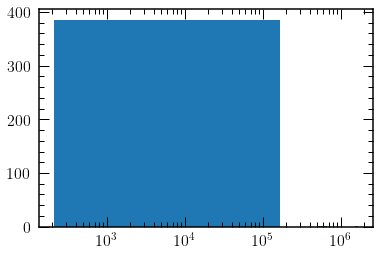

In [40]:
plt.hist(S144)
plt.xscale("log")

In [41]:
lofar.head()

,Unnamed: 0,SDSS_NAME_1,RA_1,DEC_1,REDSHIFT,PLATE_1,FIBER_1,MJD_1,TARGET_FLAG_TARGET,NSPECOBS,...,Dec_2,Separation_2,CIV_blue,CIV_EW,good,z_paul,SDSS_NAME_2,Separation_Amy,CIV_DIST_021721,Separation
91,0,104446.00+521742.8,161.191681,52.295242,1.7513,1010,182,52649,3,1,...,52.295243,0.015827,87.889379,37.666121,True,1.75054,104446.00+521742.8,0.015827,2.522933,0.002494
53,1,104547.58+551853.8,161.448257,55.314972,1.8896,906,462,52368,1048578,1,...,55.314971,0.008950,142.521789,44.743671,True,1.88758,104547.58+551853.8,0.008950,2.422896,0.003449
52,2,104718.64+541917.8,161.827698,54.321629,1.8288,906,55,52368,3145739,1,...,54.321630,0.013102,832.307354,49.698713,True,1.83249,104718.64+541917.8,0.013102,2.791469,0.005172
54,3,104829.97+550819.0,162.124893,55.138630,2.0671,906,518,52368,1048578,1,...,55.138631,0.012861,1798.550056,22.573777,True,2.07342,104829.97+550819.0,0.012861,3.848747,0.003931
92,4,104852.00+530747.2,162.216675,53.129780,1.6792,1010,509,52649,1048578,1,...,53.129779,0.007413,872.211364,51.004578,True,1.68111,104852.00+530747.2,0.007413,2.801772,0.002967


In [42]:
F_first = first[["FPEAK"]].values.flatten() * 1.e3 #convert to µJy

In [43]:
alpha = np.array([])
CIValpha = np.array([])

for i in range(len(first)):
    spec = np.log(F_first[i] / S144[first_lofar][i]) / np.log(1.4 / .144)
    print(S144[first_lofar][i], F_first[i], spec)
    alpha = np.append(alpha, spec)
    CIValpha = np.append(CIValpha, lof_dist[first_lofar][i])

210.0 282300.0 3.1672410560757283
210.0 1810.0 0.9470458715759722
17142.32127874958 271100.0 1.2139114337882153
210.0 1550.0 0.8788648369808586
4683.146521781673 3650.0 -0.10958560159260534
1357.9821173630573 6540.0 0.6911394123837098
25895.41474563964 32850.0 0.10459213061084292
210.0 1440.0 0.8464996605655345
210.0 13680.0 1.8363333429010058
1083.8436777999739 35200.0 1.53029838370278
1205.2400981569642 39230.0 1.5312791034288804
210.0 37290.0 2.277233806382925
1480.1934695760572 7970.0 0.740195729968475
7111.8727819499145 1100.0 -0.8206312716885199
8587.601952109808 1760.0 -0.696885250457562
8619.590864816008 82140.0 0.9911947755916375
1673014.2257087375 6270.0 -2.4562833849927346
7103.869610021384 2670.0 -0.4302475651833117
24743.28263456993 6080.0 -0.6171036645848563
4872.230009443109 9510.0 0.29405027988059834
532447.2580635684 2820.0 -2.3042183455008614
7621.210682415911 39100.0 0.7189487368587266
12653.20568714229 85660.0 0.8408650287346165
210.0 13650.0 1.835368087518778
210.0

Text(0.5, 0, '$\\alpha_\\mathrm{144MHz-1.4GHz}$')

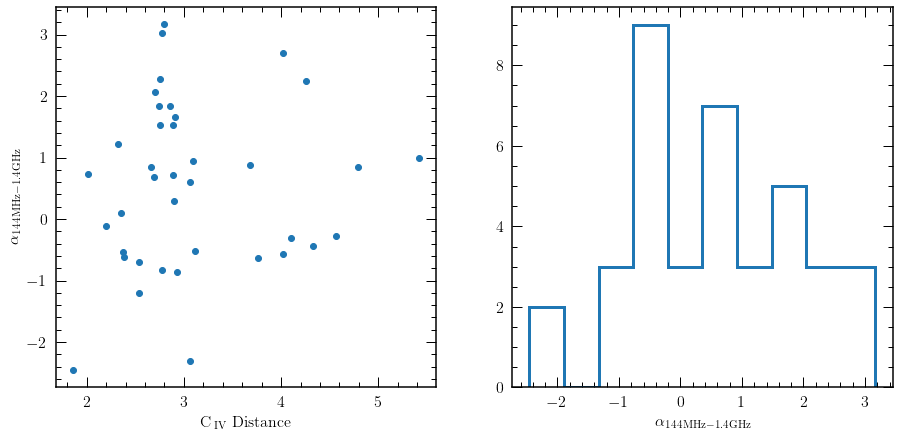

In [44]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(15,7))

ax1.scatter(CIValpha, alpha)
ax1.set_xlabel("C\,$_\mathrm{IV}$ Distance")
ax1.set_ylabel("$\\alpha_\mathrm{144MHz-1.4GHz}$")

ax2.hist(alpha, histtype="step", linewidth=3)
ax2.set_xlabel("$\\alpha_\mathrm{144MHz-1.4GHz}$")

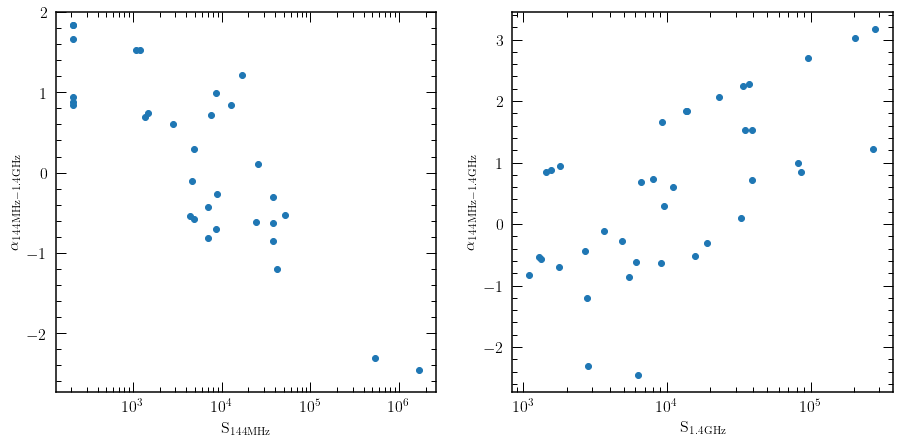

In [45]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(15,7))

ax1.scatter(S144[first_lofar], alpha) 
ax1.set_xscale("log")
#ax1.set_xlim(10**2.7, ax1.get_xlim()[1]) 
ax1.set_ylim(ax1.get_ylim()[0], 2)
ax1.set_xlabel("S$_\mathrm{144MHz}$")
ax1.set_ylabel("$\\alpha_\mathrm{144MHz-1.4GHz}$")

ax2.scatter(F_first, alpha) 
ax2.set_xscale("log")
#ax2.set_xlim(10**2.7, ax1.get_xlim()[1])
#ax2.set_ylim(ax1.get_ylim()[0], 2)
ax2.set_xlabel("S$_\mathrm{1.4GHz}$")
ax2.set_ylabel("$\\alpha_\mathrm{144MHz-1.4GHz}$")

plt.show()

Sources that aren't as bright in FIRST tend to have steeper spectral indices.  (I think these plots are saying something and not just pointing out the obvious.)  Sources with upper limits in LOFAR are plotted.

---

Include the FIRST sources in the CIV plot

Also include the Nyland+ 2020 quasars with newly launched jets

In [52]:
nyland = pd.read_csv("../Nyland_CIV.csv")
ew_nyland   = nyland[["EW_CIV"]].values.flatten()
voff_nyland = nyland[["VOFF_CIV_PEAK"]].values.flatten()

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


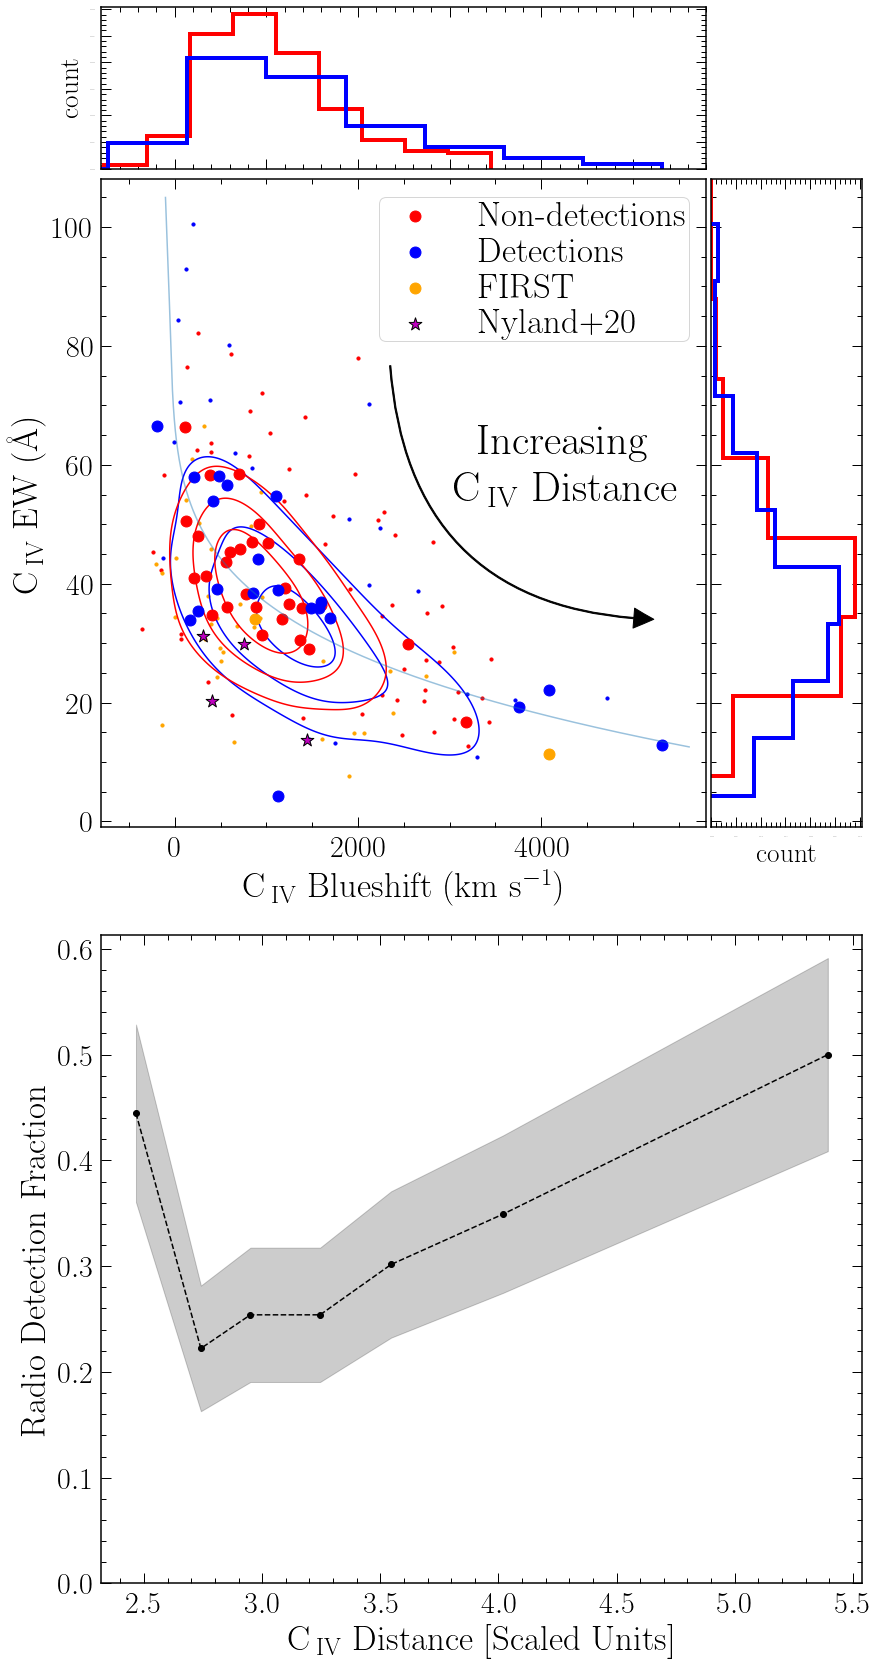

In [53]:
import matplotlib.patches as patches

#ratbins = np.linspace(min(flux_ratio), max(flux_ratio), 21)

# definitions for the axes
left, width = 0.1, 0.6
bottom, height = 0.4, 0.3
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.075]
rect_histy = [left + width + spacing, bottom, 0.15, height]

# start with a rectangular Figure
fig = plt.figure(figsize=(14, 30))


ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)

#Plot the best-fit line
ax_scatter.plot(fit[85000:,0], fit[85000:,1]+5, alpha=0.45)

#Plot scatter data
plot_contour(voff_lofar[det_lofar&good&~first_lofar], ew_lofar[det_lofar&good&~first_lofar], c="blue", nlevels=3, ax=plt.gca())
plot_contour(voff_lofar[~det_lofar&good&~first_lofar], ew_lofar[~det_lofar&good&~first_lofar], c="red", nlevels=3, ax=plt.gca())
plt.scatter(voff_lofar[first_lofar], ew_lofar[first_lofar], color="orange", s=10)


plt.scatter(voff_vla[D_vla==0], ew_vla[D_vla==0], color="r", s=120, label="Non-detections", zorder=2)
plt.scatter(voff_vla[D_vla==1], ew_vla[D_vla==1], color="b", s=120, label="Detections", zorder=2)
plt.scatter(voff_vla[D_vla==2], ew_vla[D_vla==2], color="orange", s=120, label="FIRST", zorder=2)

#Got Nyland+20 data on 4/12/2021 -- right now it is just catalogued values of 4/6 objects with CIV (only 4 appear in DR7, while all 6 are in DR14 but DR14 doesn't have CIV values)
plt.scatter(voff_nyland, ew_nyland, color="m", edgecolor="k", s=180, marker="*", label="Nyland+20")


xlims = ax_scatter.get_xlim() #Save limits before plotting
ax_scatter.set_xlim(-800,5800)
ax_scatter.set_ylim(-1,108)

#ax_scatter.set_yscale("log")
#ax_scatter.set_xlim(xlims)
ax_scatter.tick_params(axis='both', which='major', labelsize=25)


#Plot x axis distribution
ax_histx.hist(voff[~D],align='mid', histtype="step", linewidth=4.0, ls="-", color="r", density=True)
ax_histx.hist(voff[D],align='mid', histtype="step", linewidth=4.0, ls="-", color="b", density=True)
ax_histx.set_ylabel('count', fontsize=27.5)
ax_histx.tick_params(axis='both', which='major', labelsize=0)

ax_histy.hist(ew[~D],align='mid', histtype="step", linewidth=4.0, ls="-", color="r", density=True, orientation='horizontal')
ax_histy.hist(ew[D],align='mid', histtype="step", linewidth=4.0, ls="-", color="b", density=True, orientation='horizontal')
histy_xlims = ax_histy.get_xlim()
#ax_histy.plot([0,20], [1,1], "-k", alpha=0.8)
ax_histy.set_xlabel('count', fontsize=27.5)
ax_histy.tick_params(axis='both', which='major', labelsize=0)

ax_scatter.set_xlabel("C\,$_\mathrm{IV}$ Blueshift (km s$^{-1}$)", fontsize=35)
ax_scatter.set_ylabel("C\,$_\mathrm{IV}$ EW (Å)", fontsize=35)
ax_scatter.legend(loc="upper right", prop={"size": 35}, borderpad=0.05, labelspacing=0.05)
#ax_scatter.set_xlim(22.40, 25.07)
ax_scatter.tick_params(axis='both', which='major', labelsize=30)


#10/31/20: Add curved arrow to indicate increasing CIV distance
style = "Simple, tail_width=1.25, head_width=20, head_length=20"
kw = dict(arrowstyle=style, color="k")
#a1 = patches.FancyArrowPatch((950, 295), (4250, 105),
#                             connectionstyle="arc3,rad=.4", **kw)
a1 = patches.FancyArrowPatch((2350, 77), (5250, 34),
                             connectionstyle="arc3,rad=.45", **kw)
plt.gca().add_patch(a1)
plt.text(x=3300,y=62,s="Increasing", fontsize=42.5, weight='extra bold')
plt.text(x=3035,y=54,s="C\,$_\mathrm{IV}$ Distance", fontsize=42.5)


ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlim(histy_xlims)
#ax_histx.set_xscale("log")
#ax_histy.set_yscale("log")

#Add another axis for the second panel that we want to include
rect_err = [left, 0.05, width+0.155, height]
ax_err = plt.axes(rect_err)
ax_err.tick_params(direction='in', top=True, right=True)

err_region = True #Activate for err_region -- deactivate for simpler CIV histogram

if err_region:
    ax_err.plot(CIVlist, det_fraction, "--o", color="k")
    ax_err.fill_between(x, fmm, fpp, alpha=0.2, color="k")
    ax_err.tick_params(axis='both', which='major', labelsize=30)
    ax_err.set_ylabel("Radio Detection Fraction", fontsize=35)
    ax_err.set_xlabel("C\,$_\mathrm{IV}$ Distance [Scaled Units]", fontsize=35)
    ax_err.set_ylim(0.0, ax_err.get_ylim()[1])
    
else:
    ax_err.hist(CIV_dist[det_mask], histtype="step", color="b", linestyle="-", linewidth=5, zorder=2, density=True)
    ax_err.hist(CIV_dist[~det_mask], histtype="step", color="r", linestyle="-", linewidth=5, zorder=1, density=True)
    ax_err.tick_params(axis='both', which='major', labelsize=30)
    ax_err.set_xlabel("C$_\mathrm{IV}$ Distance [Scaled Units]", fontsize=35)
    ax_err.set_ylabel("Number of Quasars", fontsize=35)
    
    
plt.tight_layout()
#plt.savefig("CIV_wLOFARcontours_whistos_wDetfraction_wFIRST.pdf")
plt.savefig("../PaperPlots/fig5.pdf")
plt.show()